# Deep Neural Network for Image Classification

Before, we built a binary classifier using logistic regression to distinguish between images of cats and non-cats. However, that model performed with an accuracy of about 70%. In this notebook, we will build the same application using a deep L-layer neural network and hopefully obtain higher accuracy.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## Load Dataset

The dataset consists of labeled images, with each label indicating whether the image is a cat or not. 
We'll start by loading this dataset and exploring its structure. This will give us an idea about the number of samples, the dimensions of each image, and the distribution of the classes.    

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_y, test_set_x_orig, test_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


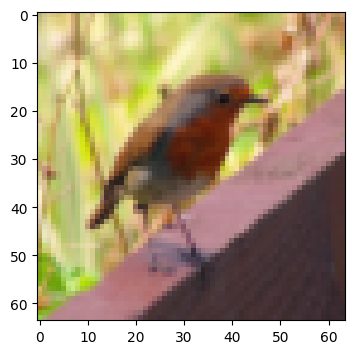

In [4]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])

decoded_class = classes[np.squeeze(train_y[:, index])].decode("utf-8")
print(f"y = {train_y[:, index]}, it's a '{decoded_class}' picture.")

## Preprocessing

Before feeding the images into our algorithm, they need to be preprocessed. Typically, this involves several steps:
- Reshaping the images to ensure they all have the same dimensions.
- Normalizing the pixel values to be between 0 and 1.
- Splitting the dataset into training and testing sets to evaluate the model's performance later on.    

In [5]:
# Number of train/test examples
m_train, m_test = train_set_x_orig.shape[0], test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

In [6]:
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Reshape and standardize the images before feeding them to the network.

<img src="images/imvector.png" style="height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [7]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

In [8]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [9]:
# Standardize the dataset
train_x = train_set_x_flatten / 255.
test_x = test_set_x_flatten / 255.

## Model Architecture

In this section, we'll build a deep NN to distinguish cat images from non-cat images. We're going to build two different models:
- A 2-layer neural network
- An L-layer deep neural network

### 2-layer Neural Network

<img src="images/2layerNN.png" style="height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT $\rightarrow$ LINEAR $\rightarrow$ RELU $\rightarrow$ LINEAR $\rightarrow$ SIGMOID $\rightarrow$ OUTPUT</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.


### L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/NlayerNN.png" style="height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR $\rightarrow$ RELU] $\times$ (L-1) $\rightarrow$ LINEAR $\rightarrow$ SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 3</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

## 2-layer Neural Network
Let's use the helper functions implemented in `utils.py` to build a 2-layer NN with the following structure:<br>
LINEAR $\rightarrow$ RELU $\rightarrow$ LINEAR $\rightarrow$ SIGMOID

In [10]:
from dnn_utils import *

In [11]:
# CONSTANTS DEFINING THE MODEL

n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [12]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Args:
        X -- input data, of shape (n_x, number of examples)
        Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
        layers_dims -- dimensions of the layers (n_x, n_h, n_y)
        num_iterations -- number of iterations of the optimization loop
        learning_rate -- learning rate of the gradient descent update rule
        print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
        parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')

        cost = compute_cost(A2, Y)
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

In [13]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614832
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.1708076297809593
Cost after iteration 1700: 0.11306524562164734
Cost after iteration 1800: 0.09629426845937145
Cost after iteration 1900: 0.08342617959726863
Cost after iteration 2000: 0.07439078704319081
Cost after iteration 2100: 0.06630748132

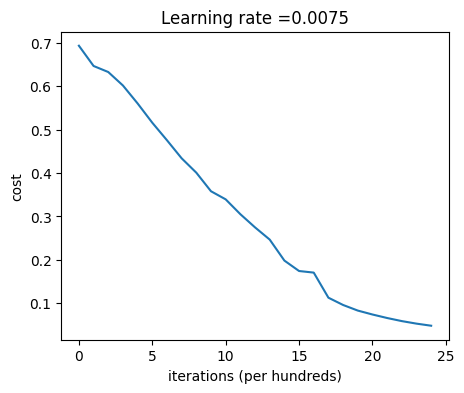

In [14]:
plot_costs(costs, learning_rate)

In [15]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [16]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


## L-layer Neural Network
Let's use the helper functions implemented in `utils.py` to build an L-layer NN with the following structure:<br>
[LINEAR $\rightarrow$ RELU] $\times$ (L - 1) $\rightarrow$ LINEAR $\rightarrow$ SIGMOID

In [17]:
# CONSTANTS
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [18]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
        X -- input data, of shape (n_x, number of examples)
        Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
        layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
        learning_rate -- learning rate of the gradient descent update rule
        num_iterations -- number of iterations of the optimization loop
        print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
        parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101356
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805356
Cost after iteration 1000: 0.3151869888600615
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.16118854665827753
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.1078392

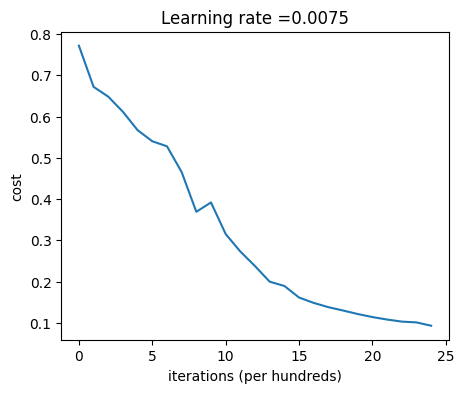

In [19]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)
plot_costs(costs, learning_rate)

In [20]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [21]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


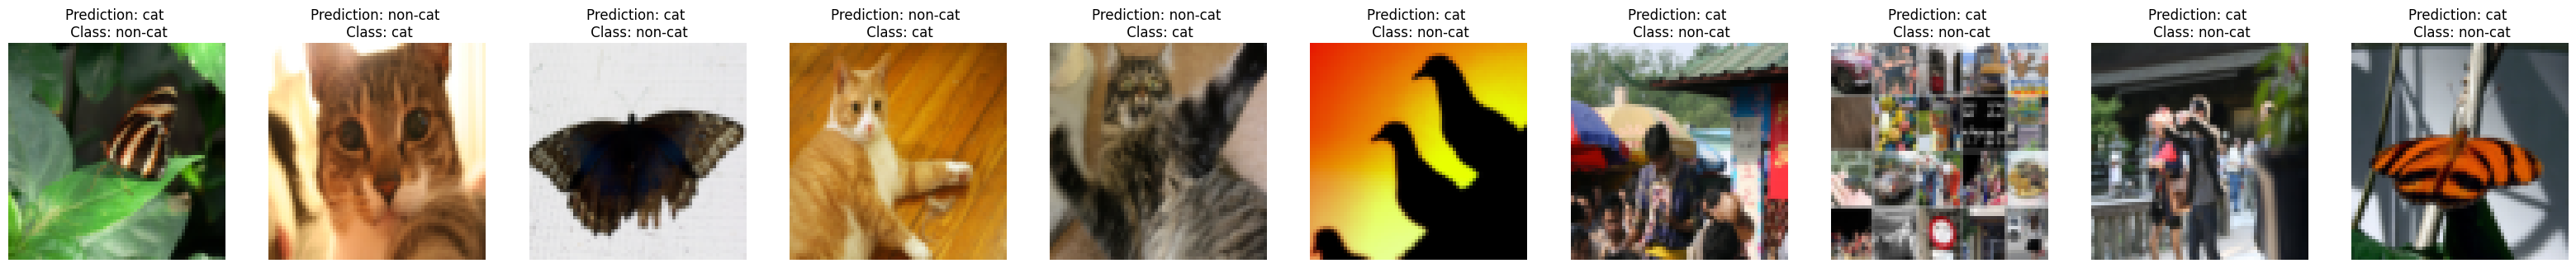

In [22]:
print_mislabeled_images(classes, test_x, test_y, pred_test)